In [7]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import gradio as gr


In [12]:
df = pd.read_csv("/content/sample_data/AmesHousing.csv")
print("Shape:", df.shape)
df.head()

Shape: (2930, 82)


,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,1,526301100,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,5,2010,WD,Normal,215000
1,2,526350040,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,...,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,105000
2,3,526351010,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,172000
3,4,526353030,20,RL,93.0,11160,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,244000
4,5,527105010,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,...,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,189900


Missing values:
 Pool QC           2917
Misc Feature      2824
Alley             2732
Fence             2358
Mas Vnr Type      1775
Fireplace Qu      1422
Lot Frontage       490
Garage Qual        159
Garage Yr Blt      159
Garage Cond        159
Garage Finish      159
Garage Type        157
Bsmt Exposure       83
BsmtFin Type 2      81
Bsmt Qual           80
Bsmt Cond           80
BsmtFin Type 1      80
Mas Vnr Area        23
Bsmt Full Bath       2
Bsmt Half Bath       2
dtype: int64
Duplicates: 0


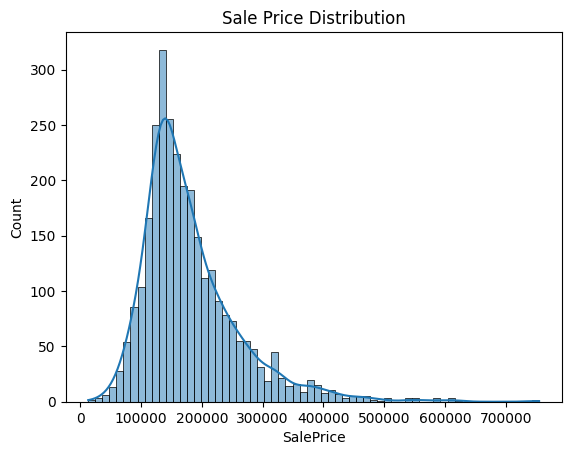

In [14]:
print("Missing values:\n", df.isnull().sum().sort_values(ascending=False).head(20))
print("Duplicates:", df.duplicated().sum())
df = df.drop_duplicates()


sns.histplot(df['SalePrice'], kde=True)
plt.title("Sale Price Distribution")
plt.show()


In [15]:
threshold = 0.3 * len(df)
df = df.dropna(thresh=threshold, axis=1)

# Fill remaining missing values
df.fillna(df.median(numeric_only=True), inplace=True)
df.fillna("None", inplace=True)

# Encode categoricals
categorical_cols = df.select_dtypes(include='object').columns
df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

# Feature scaling
scaler = StandardScaler()
X = df_encoded.drop("SalePrice", axis=1)
y = df_encoded["SalePrice"]
X_scaled = scaler.fit_transform(X)

<ipython-input-15-c17aaf69b62d>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.fillna(df.median(numeric_only=True), inplace=True)
<ipython-input-15-c17aaf69b62d>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.fillna("None", inplace=True)


In [16]:
# ✅ Step 5: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# ✅ Step 6: Model Training & Evaluation
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)
print("MSE:", mean_squared_error(y_test, y_pred))
print("R² Score:", r2_score(y_test, y_pred))

MSE: 707924136.5392855
R² Score: 0.9117031612857308


In [18]:
# Reload raw df for clean column input
raw_df = pd.read_csv("/content/sample_data/AmesHousing.csv")
raw_df.fillna("None", inplace=True)

# Get categorical features for UI
form_features = ['OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea', 'TotalBsmtSF', 'FullBath', 'YearBuilt']

def predict_price(OverallQual, GrLivArea, GarageCars, GarageArea, TotalBsmtSF, FullBath, YearBuilt):
    input_dict = {
        "OverallQual": [OverallQual],
        "GrLivArea": [GrLivArea],
        "GarageCars": [GarageCars],
        "GarageArea": [GarageArea],
        "TotalBsmtSF": [TotalBsmtSF],
        "FullBath": [FullBath],
        "YearBuilt": [YearBuilt]
    }

    input_df = pd.DataFrame(input_dict)
    all_df = df[['OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea', 'TotalBsmtSF', 'FullBath', 'YearBuilt', 'SalePrice']]
    all_df = pd.concat([all_df.drop("SalePrice", axis=1), input_df], ignore_index=True)
    input_scaled = scaler.transform(all_df)[-1].reshape(1, -1)

    prediction = model.predict(input_scaled)
    return f"Predicted House Price: ${int(prediction[0]):,}"

<ipython-input-18-e9c9dd0cb611>:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'None' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  raw_df.fillna("None", inplace=True)


In [19]:
inputs = [
    gr.Number(label="Overall Quality (1–10)"),
    gr.Number(label="Above Grade Living Area (sq ft)"),
    gr.Number(label="Garage Capacity (cars)"),
    gr.Number(label="Garage Area (sq ft)"),
    gr.Number(label="Total Basement Area (sq ft)"),
    gr.Number(label="Full Bathrooms"),
    gr.Number(label="Year Built")
]

gr.Interface(
    fn=predict_price,
    inputs=inputs,
    outputs="text",
    title="🏡 Ames House Price Predictor",
    description="Predict house prices based on important features using a trained Random Forest model."
).launch()

It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://a573f1b1d68045c498.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
